# Machine Learning with MNIST 

+ Raul Eulogio

Many people cite MNIST as a staple project to run through to learn machine learning practices. This notebook aims to do just that, I will do a quick run through of a subsample of the original MNIST noting that this usecase features the data set that is 8x8 not like the original 28x28, so its a lot simpler to do processes on. Eventually I would like to move on to do the original data set but that does require more computing power and perhaps a departure from `sklearn` to `tensorflow`. 

This is not a walkthrough and minimal explanations will be give. 

# Load Packages

I will use the preloaded data within `sklearn` which contains 8x8 matrices along with other important meta-data in a dictionary like storage. See [docs](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_digits.html#sklearn.datasets.load_digits) for more. 

In [1]:
import time
import random
import numpy as np
import pandas as pd
from sklearn import datasets
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import train_test_split, GridSearchCV

plt.style.use('ggplot')
pd.set_option('display.max_columns', 500)

# Load Data

In [2]:
digits = datasets.load_digits()

In [3]:
len(digits.target)

1797

# Exploratory Analysis

Doing some basic exploratory analysis including getting the count of the target class (numbers 0-9) and making sure there's no class imbalance. 

In [4]:
target_counts = pd.Series(digits.target)
tc_series = target_counts.value_counts()

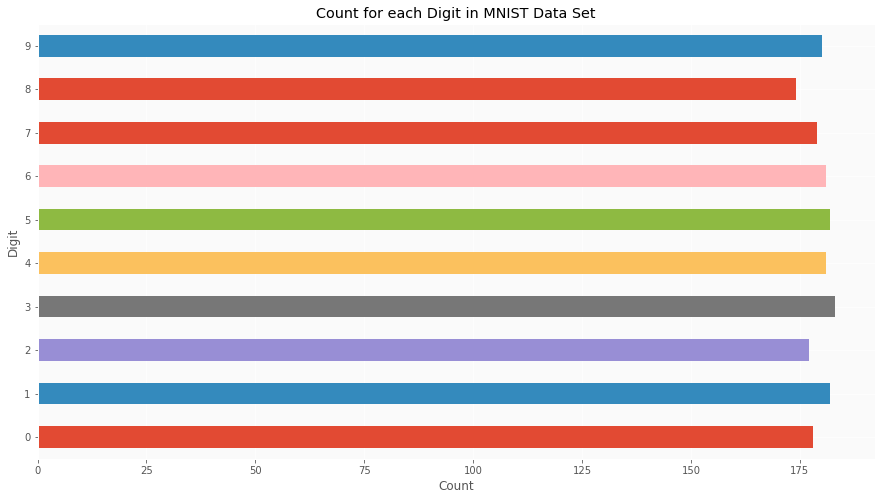

In [5]:
f, ax = plt.subplots(figsize=(15, 8))

ax.set_facecolor('#fafafa')
tc_series.reindex(list(range(0, 10))).plot.barh()
plt.title('Count for each Digit in MNIST Data Set')
plt.xlabel('Count')
plt.ylabel('Digit')
plt.show()

Let's zoom in to get a better view. 

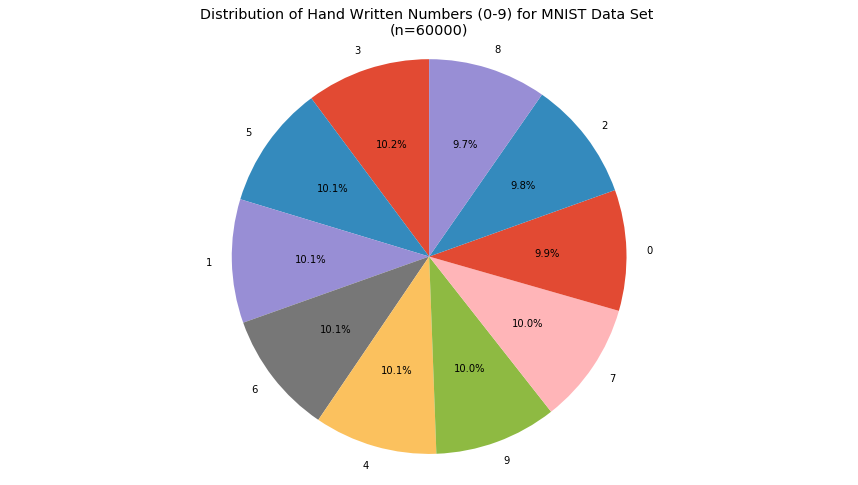

In [6]:
f, ax = plt.subplots(figsize=(15, 8))
plt.pie(tc_series,
        labels = tc_series.index,
       autopct='%1.1f%%',
       startangle=90)
plt.axis('equal')
plt.title('Distribution of Hand Written Numbers (0-9) for MNIST Data Set \n(n=60000)')
plt.show()

The number 3 seems to have the most in this sample data set, along with 1 and 5. While 8 has notably less values within the data set. 

Next let's get a small sample of 8 to visualize how the images look along with their target class for shits and giggles. 

In [7]:
random.seed(42)
# Empty list where we'll add pseudo-random numbers 
# within range of our index to plot them. 
rand_list = []

for x in range(8):
  rand_list.append(random.randint(1,1797))

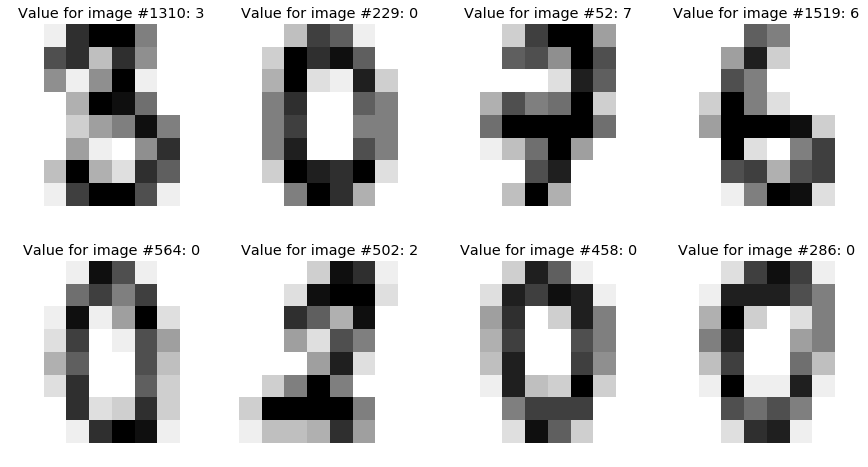

In [8]:
f, ax = plt.subplots(figsize=(15, 8))
for i in range(0, len(rand_list)):
    plt.subplot(2, 4, i + 1)
    plt.axis('off')
    plt.title('Value for image #{0}: {1}'\
    .format(rand_list[i],
              digits.target[rand_list[i]]))
    
    plt.imshow(digits.images[rand_list[i]], 
               cmap=plt.cm.gray_r,
               interpolation='nearest')

The images don't look that great due to being 8x8, so it will be interesting to see how well our model can do. 

# Data Manipulation 

Here we'll be grabbing the image data (data used to produce the images) and transform them from 8x8 arrays to 1x64. Later we'll be loading them into a data frame which will contain the target class, having an overall dimension of 1797x65.

In [9]:
data = digits.images.reshape((len(digits.images), -1))

In [10]:
digits_df = pd.DataFrame(data)

In [11]:
# Adding name to series 
target_counts = target_counts.rename('target')

In [12]:
# Concatenate the target class unto the previously create data frame
digits_df = pd.concat([digits_df, target_counts], axis=1)

In [13]:
digits_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,target
0,0.0,0.0,5.0,13.0,9.0,1.0,0.0,0.0,0.0,0.0,13.0,15.0,10.0,15.0,5.0,0.0,0.0,3.0,15.0,2.0,0.0,11.0,8.0,0.0,0.0,4.0,12.0,0.0,0.0,8.0,8.0,0.0,0.0,5.0,8.0,0.0,0.0,9.0,8.0,0.0,0.0,4.0,11.0,0.0,1.0,12.0,7.0,0.0,0.0,2.0,14.0,5.0,10.0,12.0,0.0,0.0,0.0,0.0,6.0,13.0,10.0,0.0,0.0,0.0,0
1,0.0,0.0,0.0,12.0,13.0,5.0,0.0,0.0,0.0,0.0,0.0,11.0,16.0,9.0,0.0,0.0,0.0,0.0,3.0,15.0,16.0,6.0,0.0,0.0,0.0,7.0,15.0,16.0,16.0,2.0,0.0,0.0,0.0,0.0,1.0,16.0,16.0,3.0,0.0,0.0,0.0,0.0,1.0,16.0,16.0,6.0,0.0,0.0,0.0,0.0,1.0,16.0,16.0,6.0,0.0,0.0,0.0,0.0,0.0,11.0,16.0,10.0,0.0,0.0,1
2,0.0,0.0,0.0,4.0,15.0,12.0,0.0,0.0,0.0,0.0,3.0,16.0,15.0,14.0,0.0,0.0,0.0,0.0,8.0,13.0,8.0,16.0,0.0,0.0,0.0,0.0,1.0,6.0,15.0,11.0,0.0,0.0,0.0,1.0,8.0,13.0,15.0,1.0,0.0,0.0,0.0,9.0,16.0,16.0,5.0,0.0,0.0,0.0,0.0,3.0,13.0,16.0,16.0,11.0,5.0,0.0,0.0,0.0,0.0,3.0,11.0,16.0,9.0,0.0,2
3,0.0,0.0,7.0,15.0,13.0,1.0,0.0,0.0,0.0,8.0,13.0,6.0,15.0,4.0,0.0,0.0,0.0,2.0,1.0,13.0,13.0,0.0,0.0,0.0,0.0,0.0,2.0,15.0,11.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,12.0,12.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,10.0,8.0,0.0,0.0,0.0,8.0,4.0,5.0,14.0,9.0,0.0,0.0,0.0,7.0,13.0,13.0,9.0,0.0,0.0,3
4,0.0,0.0,0.0,1.0,11.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,8.0,0.0,0.0,0.0,0.0,0.0,1.0,13.0,6.0,2.0,2.0,0.0,0.0,0.0,7.0,15.0,0.0,9.0,8.0,0.0,0.0,5.0,16.0,10.0,0.0,16.0,6.0,0.0,0.0,4.0,15.0,16.0,13.0,16.0,1.0,0.0,0.0,0.0,0.0,3.0,15.0,10.0,0.0,0.0,0.0,0.0,0.0,2.0,16.0,4.0,0.0,0.0,4


# Create Training and Test Set

In [14]:
feature_space = digits_df.iloc[:, digits_df.columns != 'target']
feature_class = digits_df.iloc[:, digits_df.columns == 'target']

In [15]:
training_set, test_set, class_set, test_class_set = train_test_split(feature_space,
                                                                     feature_class, 
                                                                     test_size=0.33, 
                                                                     random_state=42)

In [16]:
# Cleaning test sets to avoid future warning messages
class_set = class_set.values.ravel() 
test_class_set = test_class_set.values.ravel()

# Fit Model 

Now I'm going to be fitting a model utilzing `sklearn`, if you want explanations I recommend reading [here](http://blog.kaggle.com/2017/01/23/a-kaggle-master-explains-gradient-boosting/) and [here](https://machinelearningmastery.com/gentle-introduction-gradient-boosting-algorithm-machine-learning/). 

For this run through I am pre-setting parameters because I saw hyperoptization was too computationally expensive for my computer :(

In [17]:
fit = GradientBoostingClassifier(random_state=42,
                                loss = 'deviance',
                                learning_rate = 0.1, 
                                max_depth = 3, 
                                min_samples_split=2, 
                                min_samples_leaf=1)

## Train Model 

In [18]:
fit.fit(training_set, class_set)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=42, subsample=1.0, verbose=0,
              warm_start=False)

# Cross Validation on Training Set

In [19]:
n = KFold(n_splits=10)

scores = cross_val_score(fit, 
                         training_set, 
                         class_set, 
                         cv = n)

In [20]:
print("Accuracy: {0: 0.3f} (+/- {1: 0.3f})"\
              .format(scores.mean(), scores.std() / 2))

Accuracy:  0.956 (+/-  0.012)


# Test Set Metrics

In [21]:
predictions = fit.predict(test_set)

Next I created a bar chart showing the number of incorrectly predicted values. The comparison against the actual values is after. 

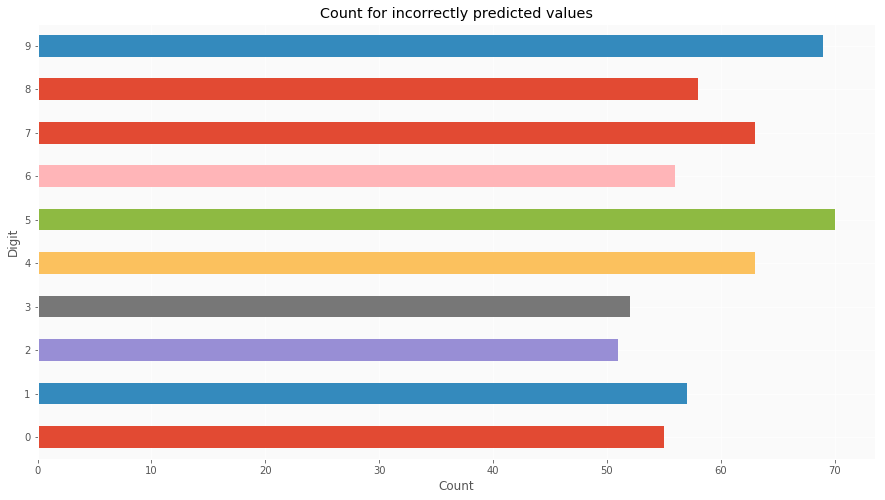

In [22]:
f, ax = plt.subplots(figsize=(15, 8))

ax.set_facecolor('#fafafa')

pd.Series(predictions).value_counts().reindex(list(range(0, 10))).plot.barh()
plt.title('Count for incorrectly predicted values')
plt.xlabel('Count')
plt.ylabel('Digit')
plt.show()

We can see the model incorrectly predicted 9 and 8 the most, doing cross tabulation we'll which values accounted for the most incorrectly predicted. 

In [23]:
pd.crosstab(index = test_class_set,
            columns = predictions, 
            rownames=['Actual values'],
            colnames=['Predicted Values'])

Predicted Values,0,1,2,3,4,5,6,7,8,9
Actual values,,,,,,,,,,
0,54,0,0,0,1,0,0,0,0,0
1,0,54,0,1,0,0,0,0,0,0
2,0,0,51,0,0,0,0,1,0,0
3,0,1,0,51,0,1,0,0,2,1
4,0,1,0,0,61,0,0,2,0,0
5,0,0,0,0,0,68,1,0,1,3
6,0,0,0,0,0,1,55,0,1,0
7,0,0,0,0,1,0,0,60,0,1
8,0,1,0,0,0,0,0,0,51,0


We can see that for when the model predicted 8, the most it confused against the actual values were 3 and 9. Whereas for when the model predicted 9, the most it confused 8 for was 5.  

Now let's do some basic metrics for the test set. 

In [24]:
accuracy = fit.score(test_set, test_class_set)

print("Here is our mean accuracy on the test set:\n {0:.3f}"\
      .format(accuracy))

Here is our mean accuracy on the test set:
 0.958


In [25]:
test_error_rate = 1 - accuracy
print("The test error rate for our model is:\n {0: .4f}"\
      .format(test_error_rate))

The test error rate for our model is:
  0.0421


# Visualizing Incorrect Predictions

Finally I'll visualize the images that were predicted incorrectly including the actual value and the predicted value to show a visual on where the model tripped up the most.  

In [26]:
incorr_index = []
for i in range(0, len(predictions)):
    if (predictions[i] != test_class_set[i]):
        incorr_index.append(i)

In [27]:
# Gathering the index of the incorrect 
# test set values to use within the original data frame
df_index = test_set.iloc[incorr_index].index

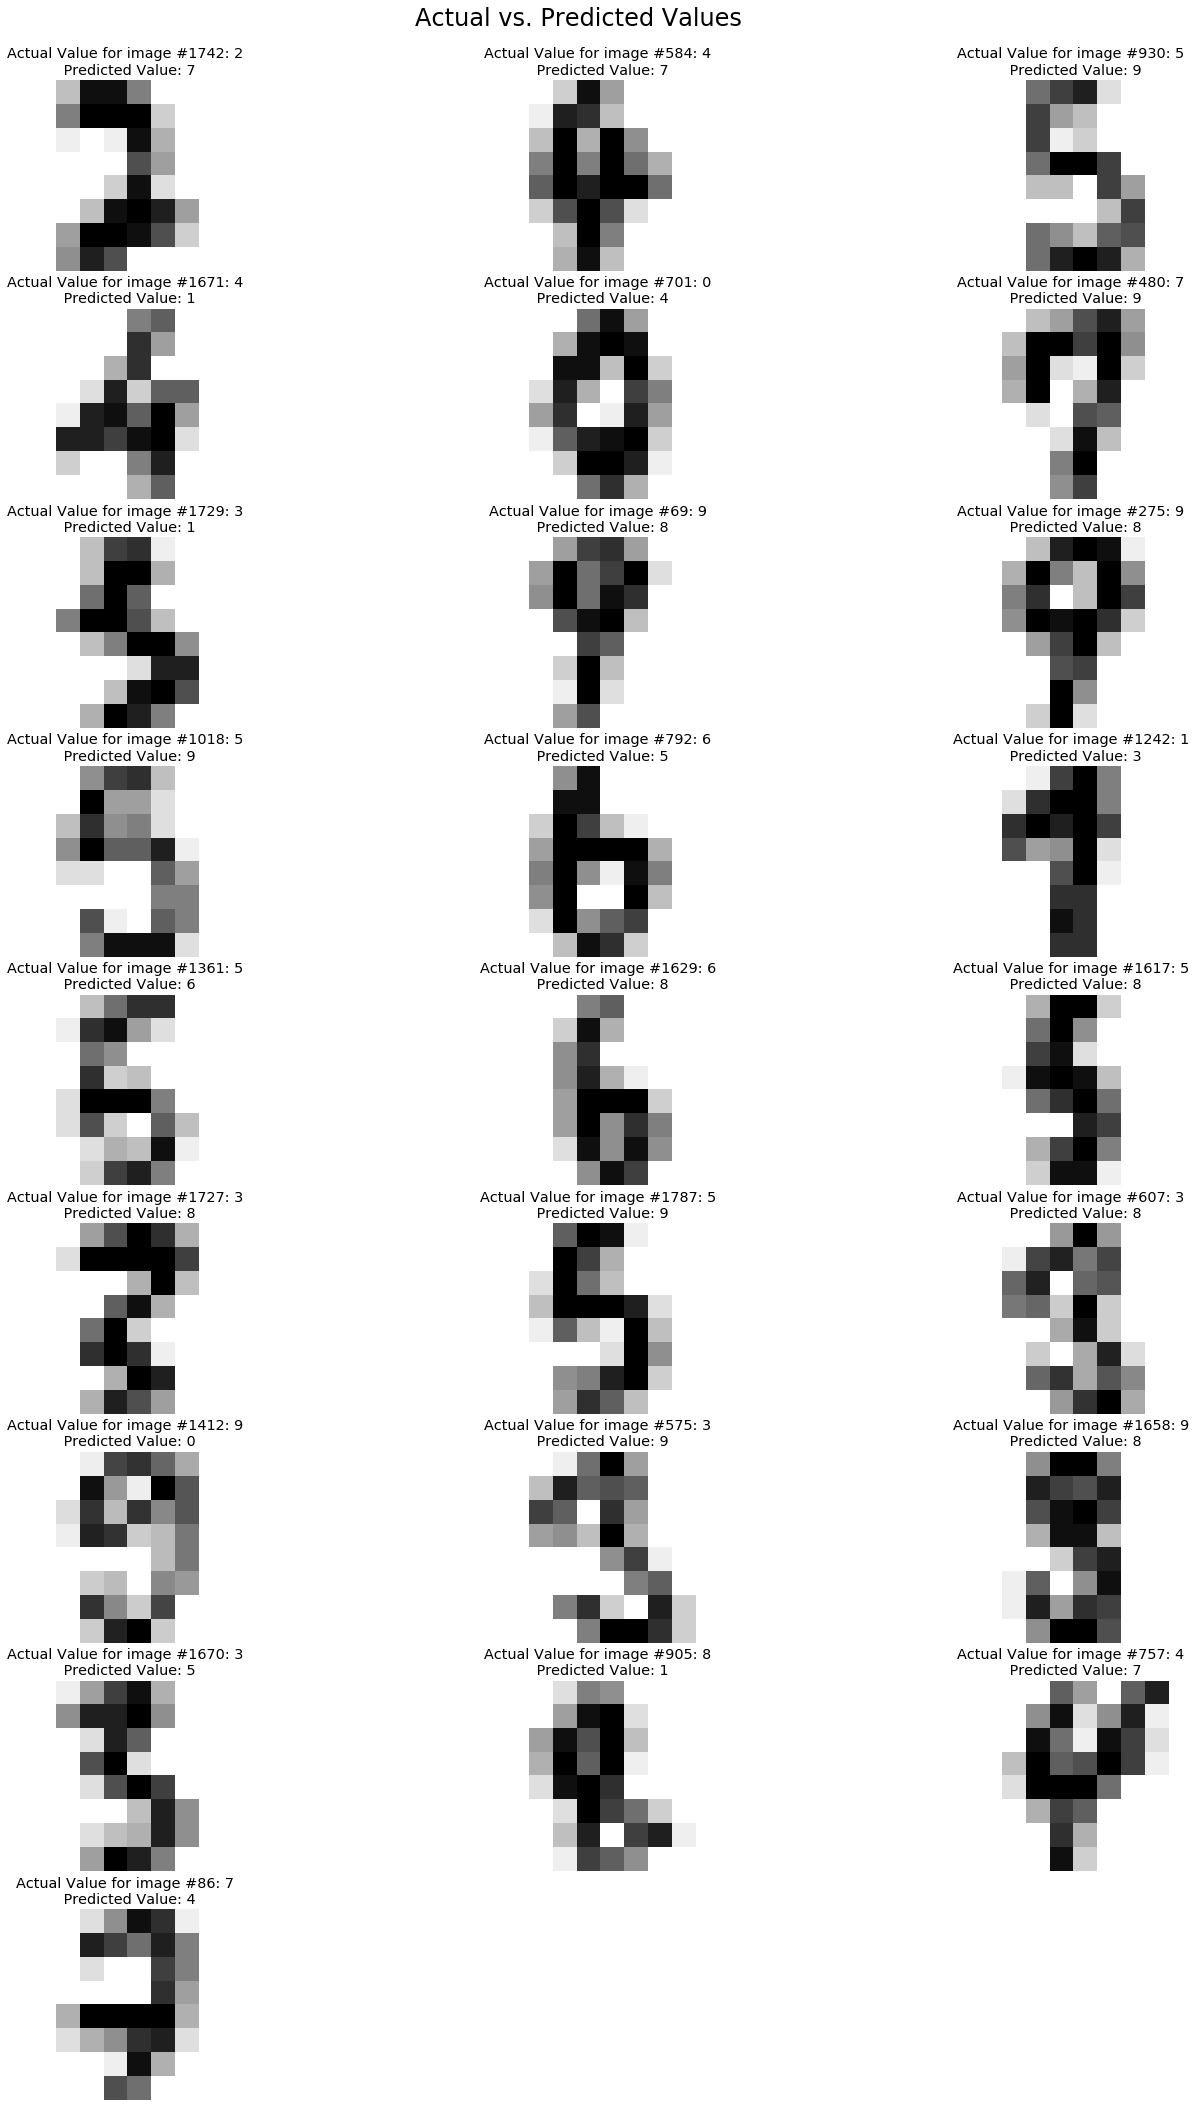

In [28]:
f, ax = plt.subplots(figsize=(24, 34))


for i in range(0, len(incorr_index)):
    plt.subplot(9, 3, i + 1)
    plt.axis('off')
    plt.title('Actual Value for image #{0}: {1} \n Predicted Value: {2}'\
    .format(df_index[i],
            digits.target[df_index[i]],
           predictions[incorr_index[i]]))
    
    plt.imshow(digits.images[df_index[i]], 
               cmap=plt.cm.gray_r,
               interpolation='nearest')

f.suptitle('Actual vs. Predicted Values', size = 24)
f.subplots_adjust(top=0.95)

# Conclusions

Utilizing Gradient Boosting we were able to create a model that performed well on multi-class learning. Of course this is far from perfect and shows the limitations when not doing a cohesive modeling, but it did help as an introduction to image modeling, albeit a very watered down intro, but an intro none the less. 

Thank you for reading. 
Questions concerns, reach out to me!